## Population extrapolation

### Goal
We are given population observations (year -> population).  
We hold out the 2025 value and use data up to 2020 to predict population in 2025, then compare against the reference:

- Reference: 2025: 347,275,807

### Methods
1. Newton polynomial interpolation via divided differences
2. Natural cubic spline interpolation, with own Thomas (tridiagonal) solver to compute spline moments.
3. Least squares polynomial regression

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tsv = """\
1910,92228496
1920,106021537
1930,123202624
1940,132164569
1950,151325798
1960,179323175
1970,203211926
1980,226545805
1990,248709873
2000,281421906
2010,308745538
2020,331449281
2025,347275807
"""

data = np.array([list(map(float, line.split(","))) for line in tsv.strip().splitlines()])
years = data[:, 0]
pop = data[:, 1]

year_ref = 2025.0
pop_ref = float(pop[years == year_ref][0])

mask_train = years <= 2020
x = years[mask_train]
y = pop[mask_train]

def fmt_int(z):
    return f"{int(round(float(z))):,}"

print("Train points:", len(x), f"({int(x.min())}..{int(x.max())})")
print("Reference:", int(year_ref), "->", fmt_int(pop_ref))


Train points: 12 (1910..2020)
Reference: 2025 -> 347,275,807


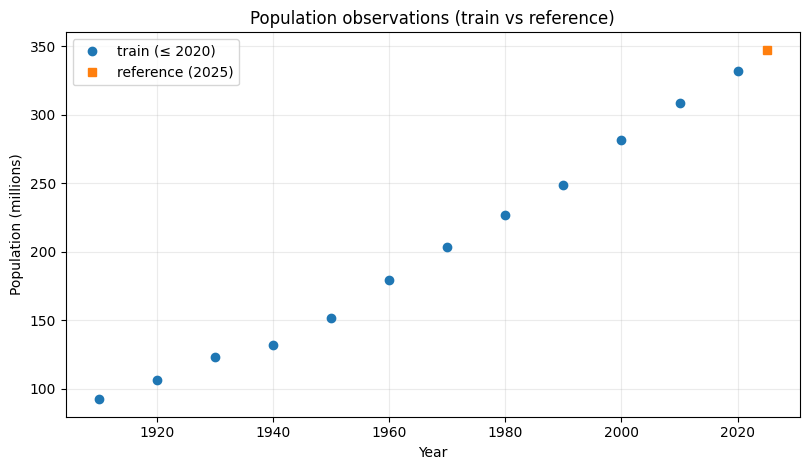

In [4]:
plt.figure(figsize=(8.2, 4.8))
plt.plot(x, y / 1e6, "o", label="train (≤ 2020)")
plt.plot([year_ref], [pop_ref / 1e6], "s", label="reference (2025)")
plt.xlabel("Year")
plt.ylabel("Population (millions)")
plt.title("Population observations (train vs reference)")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()


## 1) Newton polynomial interpolation

We build the unique interpolating polynomial through all training points
$$
P(t)=a_0 + a_1(t-t_0)+a_2(t-t_0)(t-t_1)+\cdots
$$

$$
t = \frac{\text{year} - \text{year}_0}{10}
$$


In [6]:
x0 = x[0]
t = (x - x0) / 10.0
t_ref = (year_ref - x0) / 10.0

def newton_divided_differences(xn, yn):
    xn = np.asarray(xn, float)
    a = np.asarray(yn, float).copy()
    n = len(xn)
    for j in range(1, n):
        a[j:n] = (a[j:n] - a[j-1:n-1]) / (xn[j:n] - xn[0:n-j])
    return a

def newton_eval(xn, a, xq):
    xn = np.asarray(xn, float)
    a = np.asarray(a, float)
    xq = np.asarray(xq, float)
    p = np.zeros_like(xq) + a[-1]
    for k in range(len(xn) - 2, -1, -1):
        p = p * (xq - xn[k]) + a[k]
    return p

a_newton = newton_divided_differences(t, y)
pred_newton = float(newton_eval(t, a_newton, t_ref))

print("Newton prediction (2025):", fmt_int(pred_newton))
print("Abs error vs reference:", fmt_int(abs(pred_newton - pop_ref)))
print("Rel error:", abs(pred_newton - pop_ref) / pop_ref)


Newton prediction (2025): 873,146,339
Abs error vs reference: 525,870,532
Rel error: 1.5142734419110484


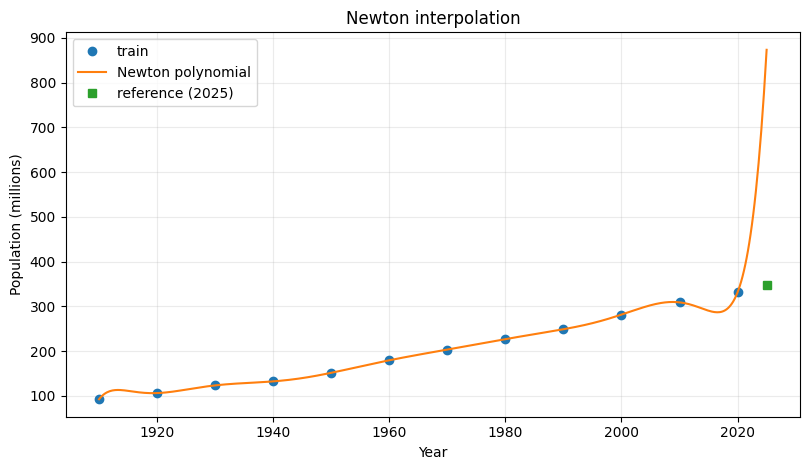

In [8]:
grid_years = np.linspace(x.min(), year_ref, 500)
grid_t = (grid_years - x0) / 10.0
grid_newton = newton_eval(t, a_newton, grid_t)

plt.figure(figsize=(8.2, 4.8))
plt.plot(x, y / 1e6, "o", label="train")
plt.plot(grid_years, grid_newton / 1e6, label="Newton polynomial")
plt.plot([year_ref], [pop_ref / 1e6], "s", label="reference (2025)")
plt.xlabel("Year")
plt.ylabel("Population (millions)")
plt.title("Newton interpolation")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()


## 2) Natural cubic spline interpolation

A cubic spline is cubic, interpolates all points, and has continuous first and second derivatives.

We use natural boundary conditions:
$$
S''(x_0)=S''(x_n)=0
$$

Let $M_i = S''(x_i)$ be spline moments. For internal nodes $$i=1,\dots,n-1:$$
$$
h_{i-1}M_{i-1} + 2(h_{i-1}+h_i)M_i + h_iM_{i+1}
= 6\left(\frac{y_{i+1}-y_i}{h_i} - \frac{y_i-y_{i-1}}{h_{i-1}}\right)
$$

This is a tridiagonal system, solved by Thomas algorithm.


In [11]:
def thomas_solve(a, b, c, d):
    a = np.asarray(a, float).copy()
    b = np.asarray(b, float).copy()
    c = np.asarray(c, float).copy()
    d = np.asarray(d, float).copy()
    n = len(b)

    for i in range(1, n):
        w = a[i - 1] / b[i - 1]
        b[i] -= w * c[i - 1]
        d[i] -= w * d[i - 1]

    xsol = np.zeros(n, float)
    xsol[-1] = d[-1] / b[-1]
    for i in range(n - 2, -1, -1):
        xsol[i] = (d[i] - c[i] * xsol[i + 1]) / b[i]
    return xsol

def natural_cubic_spline_moments(xn, yn):
    xn = np.asarray(xn, float)
    yn = np.asarray(yn, float)
    h = np.diff(xn)

    n = len(xn) - 1
    if n < 2:
        return np.zeros(n + 1, float)

    a = h[:-1]
    b = 2 * (h[:-1] + h[1:])
    c = h[1:]
    rhs = 6 * ((np.diff(yn[1:]) / h[1:]) - (np.diff(yn[:-1]) / h[:-1]))

    M_inner = thomas_solve(a, b, c, rhs)
    M = np.zeros(n + 1, float)
    M[1:n] = M_inner
    return M

def spline_eval(xn, yn, M, xq):
    xn = np.asarray(xn, float)
    yn = np.asarray(yn, float)
    M = np.asarray(M, float)
    xq = np.asarray(xq, float)

    n = len(xn) - 1
    idx = np.searchsorted(xn, xq) - 1
    idx = np.clip(idx, 0, n - 1)

    xi = xn[idx]
    xi1 = xn[idx + 1]
    hi = xi1 - xi

    A = (xi1 - xq) / hi
    B = (xq - xi) / hi

    yi = yn[idx]
    yi1 = yn[idx + 1]
    Mi = M[idx]
    Mi1 = M[idx + 1]

    S = (Mi * (A**3) * hi**2 / 6.0
         + Mi1 * (B**3) * hi**2 / 6.0
         + (yi - Mi * hi**2 / 6.0) * A
         + (yi1 - Mi1 * hi**2 / 6.0) * B)
    return S

M = natural_cubic_spline_moments(x, y)
pred_spline = float(spline_eval(x, y, M, year_ref))

print("Spline prediction (2025):", fmt_int(pred_spline))
print("Abs error vs reference:", fmt_int(abs(pred_spline - pop_ref)))
print("Rel error:", abs(pred_spline - pop_ref) / pop_ref)


Spline prediction (2025): 342,560,860
Abs error vs reference: 4,714,947
Rel error: 0.013576951878600908


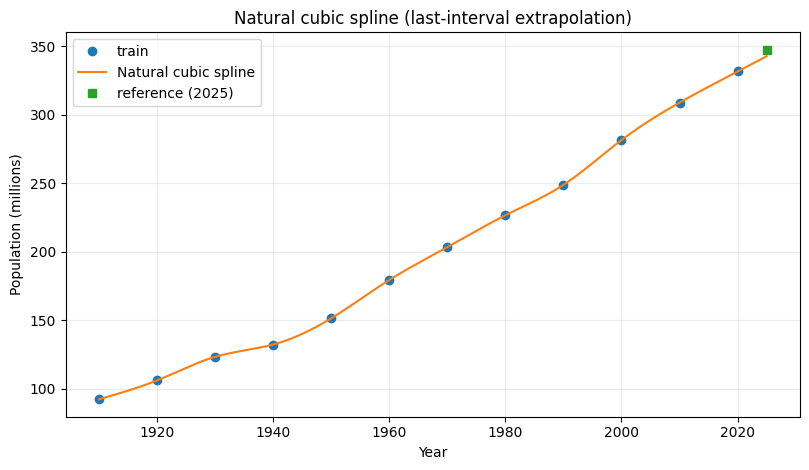

In [12]:
grid_spline = spline_eval(x, y, M, grid_years)

plt.figure(figsize=(8.2, 4.8))
plt.plot(x, y / 1e6, "o", label="train")
plt.plot(grid_years, grid_spline / 1e6, label="Natural cubic spline")
plt.plot([year_ref], [pop_ref / 1e6], "s", label="reference (2025)")
plt.xlabel("Year")
plt.ylabel("Population (millions)")
plt.title("Natural cubic spline (last-interval extrapolation)")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()


## 3) Least squares method (polynomial regression)

We fit a polynomial of degree $m$:
$$
p_m(t)=c_0 + c_1 t + \cdots + c_m t^m
$$
by minimizing:
$$
\min_c \|A c - y\|_2^2
$$
where \(A\) is the Vandermonde design matrix.

In [13]:
def poly_ls_fit(tn, yn, deg):
    tn = np.asarray(tn, float)
    yn = np.asarray(yn, float)
    A = np.vander(tn, deg + 1, increasing=True)
    coeffs, *_ = np.linalg.lstsq(A, yn, rcond=None)
    return coeffs

def poly_eval(coeffs, tq):
    coeffs = np.asarray(coeffs, float)
    tq = np.asarray(tq, float)
    p = np.zeros_like(tq) + coeffs[-1]
    for k in range(len(coeffs) - 2, -1, -1):
        p = p * tq + coeffs[k]
    return p

deg_list = list(range(1, 7))
rows = []
for deg in deg_list:
    c = poly_ls_fit(t, y, deg)
    pred = float(poly_eval(c, t_ref))
    yhat = poly_eval(c, t)
    rmse = float(np.sqrt(np.mean((yhat - y) ** 2)))
    rows.append({
        "degree": deg,
        "pred_2025": pred,
        "abs_err": abs(pred - pop_ref),
        "rel_err": abs(pred - pop_ref) / pop_ref,
        "train_RMSE": rmse,
    })

ls_table = pd.DataFrame(rows).sort_values(["abs_err", "degree"]).reset_index(drop=True)
ls_table_fmt = ls_table.copy()
ls_table_fmt["pred_2025"] = ls_table_fmt["pred_2025"].map(fmt_int)
ls_table_fmt["abs_err"] = ls_table_fmt["abs_err"].map(fmt_int)
ls_table_fmt["rel_err"] = ls_table_fmt["rel_err"].map(lambda z: f"{z:.6f}")
ls_table_fmt["train_RMSE"] = ls_table_fmt["train_RMSE"].map(lambda z: fmt_int(z))
ls_table_fmt


,degree,pred_2025,abs_err,rel_err,train_RMSE
0,3,"346,182,435","1,093,372",0.003148,"2,754,621"
1,5,"345,046,906","2,228,901",0.006418,"2,572,785"
2,4,"342,947,049","4,328,758",0.012465,"2,606,899"
3,2,"352,446,028","5,170,221",0.014888,"3,524,625"
4,6,"333,015,932","14,259,875",0.041062,"2,040,005"
5,1,"332,872,554","14,403,253",0.041475,"9,267,702"


Best LS degree by abs error: 3
LS prediction (2025): 346,182,435
Abs error vs reference: 1,093,372
Rel error: 0.0031484250287300342


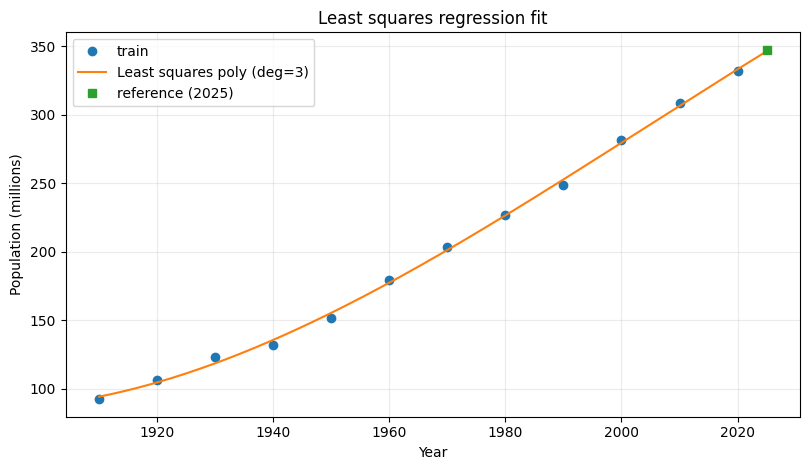

In [14]:
best_deg = int(ls_table.iloc[0]["degree"])
c_best = poly_ls_fit(t, y, best_deg)
pred_ls = float(poly_eval(c_best, t_ref))

print("Best LS degree by abs error:", best_deg)
print("LS prediction (2025):", fmt_int(pred_ls))
print("Abs error vs reference:", fmt_int(abs(pred_ls - pop_ref)))
print("Rel error:", abs(pred_ls - pop_ref) / pop_ref)

grid_ls = poly_eval(c_best, grid_t)

plt.figure(figsize=(8.2, 4.8))
plt.plot(x, y / 1e6, "o", label="train")
plt.plot(grid_years, grid_ls / 1e6, label=f"Least squares poly (deg={best_deg})")
plt.plot([year_ref], [pop_ref / 1e6], "s", label="reference (2025)")
plt.xlabel("Year")
plt.ylabel("Population (millions)")
plt.title("Least squares regression fit")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()


## Final comparison
We compare all three methods against the reference.


In [17]:
summary = pd.DataFrame([
    {"method": "Newton polynomial interpolation", "pred_2025": pred_newton},
    {"method": "Natural cubic spline", "pred_2025": pred_spline},
    {"method": f"Least squares polynomial regression", "pred_2025": pred_ls},
])

summary["abs_err"] = (summary["pred_2025"] - pop_ref).abs()
summary["rel_err"] = summary["abs_err"] / pop_ref

summary_fmt = summary.copy()
summary_fmt["pred_2025"] = summary_fmt["pred_2025"].map(fmt_int)
summary_fmt["abs_err"] = summary_fmt["abs_err"].map(fmt_int)
summary_fmt["rel_err"] = summary_fmt["rel_err"].map(lambda z: f"{z:.6f}")
summary_fmt


,method,pred_2025,abs_err,rel_err
0,Newton polynomial interpolation,"873,146,339","525,870,532",1.514273
1,Natural cubic spline,"342,560,860","4,714,947",0.013577
2,Least squares polynomial regression,"346,182,435","1,093,372",0.003148


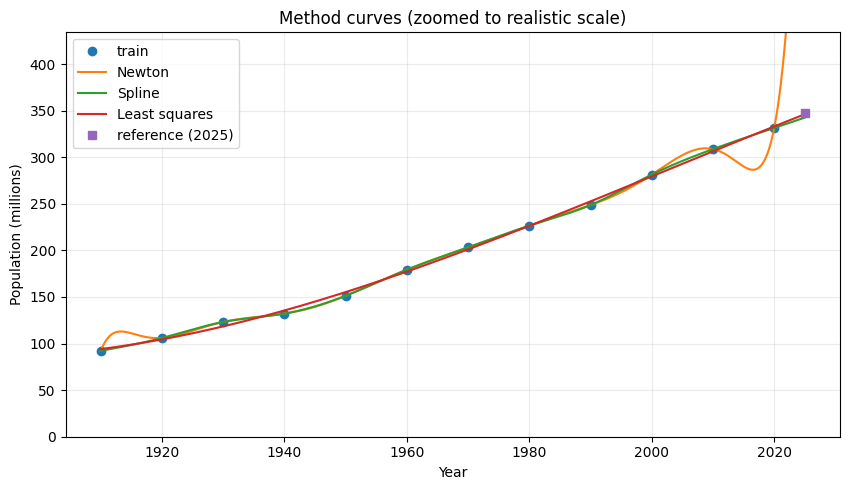

In [18]:
plt.figure(figsize=(8.6, 5.0))
plt.plot(x, y / 1e6, "o", label="train")

plt.plot(grid_years, grid_newton / 1e6, label="Newton")
plt.plot(grid_years, grid_spline / 1e6, label="Spline")
plt.plot(grid_years, grid_ls / 1e6, label="Least squares")

plt.plot([year_ref], [pop_ref / 1e6], "s", label="reference (2025)")

plt.ylim(0, max(pop_ref, y.max()) / 1e6 * 1.25)
plt.xlabel("Year")
plt.ylabel("Population (millions)")
plt.title("Method curves (zoomed to realistic scale)")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()
